In [17]:
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
from torch import device, cuda
from torch.optim import Adam
from torch import nn
import torch

import torchvision

from tqdm import trange, tqdm

from ViT import MyViT

# import resnet50 from torchvision
from torchvision.models import resnet18, ResNet18_Weights
from einops import repeat
from einops.layers.torch import Rearrange

class ClassifierWithFeatureExtraction(nn.Module):
    def __init__(self, feature_model: nn.Module, rearrage_layer: Rearrange, classifier_Model: nn.Module, **kwargs):
        super().__init__(**kwargs)
        if not isinstance(feature_model.fc, nn.Identity):
            feature_model.fc = nn.Identity() # The classifier (fc) layer of the feature model has to be set to nn.Identity previously
        self.feature_model = feature_model 
        self.arranging_features = rearrage_layer
        self.classifier_Model = classifier_Model
    
    def forward(self, image: torch.Tensor):
        features = self.feature_model(image)    # this will return b x L x 1 x 1 (L is the number of features)
        features = self.arranging_features(features)
        return self.classifier_Model(features)

In [10]:
# Defining model and training options
mydevice = device("cuda" if cuda.is_available() else "cpu")
print("Using device: ", device, f"({cuda.get_device_name(device)})" if cuda.is_available() else "")

transform = transforms.Compose([transforms.Resize(256, interpolation = transforms.InterpolationMode.BILINEAR),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                #transforms.Grayscale(num_output_channels=3), # ResNet needs RGB channels
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform) #60,000 images
test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform) #10,000 images

train_loader = DataLoader(train_set, shuffle=True, batch_size=128) #batch size of 128, 469 batches
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)  #batch size of 128, 79 batches

classes = train_set.classes

Using device:  <class 'torch.device'> (NVIDIA GeForce RTX 3060 Laptop GPU)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


torch.Size([3, 224, 224])


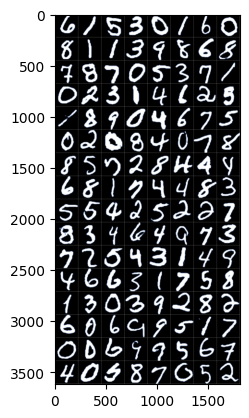

In [4]:
import matplotlib.pyplot as plt
import numpy as np
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.cpu().mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images using our helper function
matplotlib_imshow(img_grid)
print(images[0].shape)

In [9]:
# We gonna check the output shape of the feature extraction model
resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity()
resnet.to(mydevice)
images = images.to(mydevice)
features = resnet(images) # this is b x 512; 512 = c x h w
print('before re arranging: ', features.shape)
rearrange_layer = Rearrange('b (c w h) -> b c h w', h = 32, w = 16)
features = rearrange_layer(features)
print('after re arranging: ', features.shape)



before re arranging:  torch.Size([128, 512])
after re arranging:  torch.Size([128, 1, 32, 16])


In [20]:

resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity()
resnet.to(mydevice)

myvit = MyViT(
    num_classes=10, # 0 to 9 digits
    img_size=(32, 16), # the resulting dim T will be 32x16=512
    num_channels = 1,
    patch_size=(4, 4), # dim d for the token vectors will be 16
    dim=4*4, # final resolution for pixels in each patch (embedded vectors (tokens) dim d)
    depth = 2, # Number of transformer blocks (MSA+MLP)
    dim_head = 16, # dimension of the heads in the MSA (dim T) -> matrixes Q, K, V in Transformer are Txd dimensions
    heads = 8, # number of heads in the MSA
    mlp_dim = 2, # dimension of the hidden layer in the MLP
    dropout = 0.1, # dropout rate for layers in Transformer blocks
    embedding_dropout = 0.1 # dropout rate for the tokens+class token+positional encoding before the transformer
  ).to(mydevice)

model = MyVitWithFeature(
    feature_model=resnet, 
    rearrage_layer=Rearrange('b (c w h) -> b c h w', h = 32, w = 16), 
    vit_model=myvit
  ).to(mydevice)

N_EPOCHS = 5
LR = 0.005

next(model.parameters()).is_cuda

True

In [19]:
print(model)

MyVitWithFeature(
  (feature_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [21]:
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for iteration, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False)):
        inputs, labels = batch
        inputs, labels = inputs.to(mydevice), labels.to(mydevice)
        y_hat = model(inputs)
        loss = criterion(y_hat, labels)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Training:  20%|██        | 1/5 [02:00<08:02, 120.74s/it]

Epoch 1/5 loss: 0.22


Training:  40%|████      | 2/5 [04:06<06:11, 123.96s/it]

Epoch 2/5 loss: 0.05


Training:  60%|██████    | 3/5 [06:15<04:11, 125.85s/it]

Epoch 3/5 loss: 0.04


Training:  80%|████████  | 4/5 [08:24<02:07, 127.19s/it]

Epoch 4/5 loss: 0.03


Training: 100%|██████████| 5/5 [10:35<00:00, 127.01s/it]

Epoch 5/5 loss: 0.02


In [22]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(mydevice), y.to(mydevice)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing: 100%|██████████| 79/79 [00:13<00:00,  5.69it/s]

Test loss: 0.03
Test accuracy: 99.08%
